In [2]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 3.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [6]:
!pip install datasets

In [5]:
import transformers
from transformers import AutoTokenizer
from datasets import load_dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
# Load the emotions data set
emotions = load_dataset("emotion", trust_remote_code=True)

# Tokenize the text data
tokenizer=AutoTokenizer.from_pretrained("distilbert-base-cased")
def tokenize(batch):
 return tokenizer(batch["text"], padding=True, truncation=True)

data_encoded= emotions.map(tokenize,batched=True, batch_size=None)
lbl2Id = data_encoded['train'].features['label']._str2int

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [11]:
# Functions to plot confusion matrix and compute performance metrics
def plot_confusion_matrix(y_true, y_predictions, labels, normalize=None ):
    cm = confusion_matrix(y_true, y_predictions,labels=labels,normalize=normalize)

    fig, ax = plt.subplots(figsize=(6,6))
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(lbl2Id.keys()))
    cm_disp.plot(cmap='Blues',colorbar=False,values_format='.2f',ax=ax)
    plt.title("Confusion Matrix")
    plt.show()


def compute_metrics(EvalPrediction):
    labels = EvalPrediction.label_ids
    preds = EvalPrediction.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, "f1_score": f1}

## Fine tuning the transformer for classification

In [13]:
# loging into hugging face
from huggingface_hub import notebook_login
notebook_login()

In [14]:
# Load pretrained transformer
from transformers import AutoModelForSequenceClassification
num_labels = data_encoded['train'].features['label'].num_classes
model_ckpt = 'distilbert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)
model

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [16]:
# Defining all the hyperparameters for training run
from transformers import TrainingArguments, Trainer
batch_size=64
logging_steps = len(data_encoded['train'])//batch_size
model_name="distilbert-base-uncased-finetuned-emotion"
# training arguments
training_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=6,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 evaluation_strategy='epoch',
                                 disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='error'
                                 )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
# Enable CUDA_LAUNCH_BLOCKING for more informative error messages
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = data_encoded["train"],
                  eval_dataset = data_encoded["validation"],
                  tokenizer=tokenizer
                  )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,1.511600,1.280851,0.531500,0.473391
2,0.873100,0.553261,0.834000,0.827333
3,0.432300,0.393958,0.863000,0.862300
4,0.273700,0.317912,0.890000,0.890014
5,0.209800,0.296263,0.893500,0.893211
6,0.173400,0.290544,0.896000,0.896227


TrainOutput(global_step=1500, training_loss=0.5789906997680664, metrics={'train_runtime': 820.1674, 'train_samples_per_second': 117.049, 'train_steps_per_second': 1.829, 'total_flos': 2334904448256000.0, 'train_loss': 0.5789906997680664, 'epoch': 6.0})

In [20]:
pred_output = trainer.predict(data_encoded["validation"])
pred_output.metrics

{'test_loss': 0.29054418206214905,
 'test_accuracy': 0.896,
 'test_f1_score': 0.8962270004761831,
 'test_runtime': 4.1385,
 'test_samples_per_second': 483.27,
 'test_steps_per_second': 7.732}

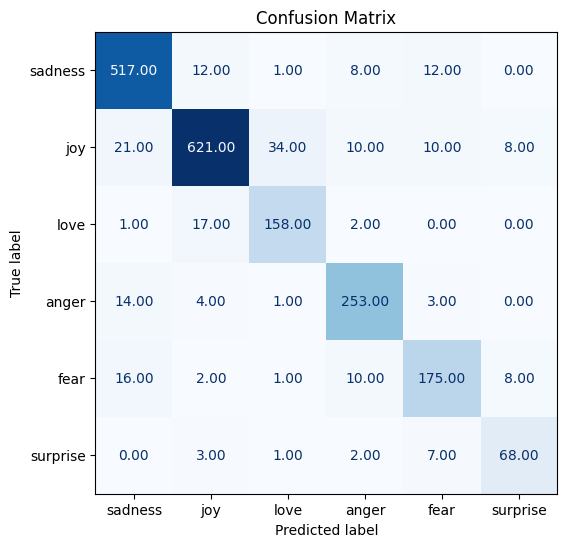

In [32]:
# Confusion matrix
y_pred = np.argmax(pred_output.predictions, axis=-1)
y_valid = data_encoded["validation"]['label']
# plot the confusion matrix
plot_confusion_matrix(y_valid, y_pred, labels=list(lbl2Id.values()),normalize=None)

In [18]:
# Push the model on hugging face hub
trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1720857423.6d536e928978.571.0:   0%|          | 0.00/8.90k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sfarrukh/distilbert-base-uncased-finetuned-emotion/commit/962a46ccffafb5b27fc529cb3c5617e0c077a6be', commit_message='Training completed!', commit_description='', oid='962a46ccffafb5b27fc529cb3c5617e0c077a6be', pr_url=None, pr_revision=None, pr_num=None)

In [24]:
# load the model from hub space
from transformers import pipeline
model_id="sfarrukh/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification",model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

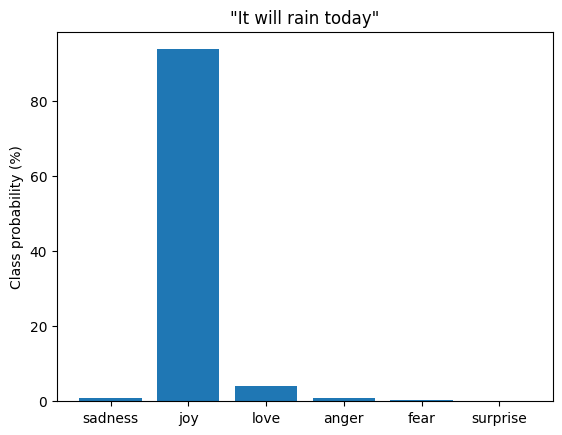

In [35]:
# test on new data
new_tweet="It will rain today"
emotion_label = classifier(new_tweet,return_all_scores=True)
df=pd.DataFrame(emotion_label[0])
df['label']=lbl2Id.keys()
plt.bar(df['label'],df['score']*100)
plt.title(f'"{new_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()